In [22]:
import torch
from transformers import *
# tokenizer = AutoTokenizer.from_pretrained("TODBERT/TOD-BERT-JNT-V1")
# tod_bert = AutoModel.from_pretrained("TODBERT/TOD-BERT-JNT-V1")

tokenizer = RobertaTokenizerFast.from_pretrained("roberta-large-mnli")
bert = RobertaModel.from_pretrained("roberta-large-mnli")

Downloading: 100%|██████████| 899k/899k [00:01<00:00, 716kB/s]
Downloading: 100%|██████████| 456k/456k [00:01<00:00, 387kB/s]
Downloading: 100%|██████████| 1.36M/1.36M [00:01<00:00, 690kB/s]
Downloading: 100%|██████████| 688/688 [00:00<00:00, 233kB/s]
Downloading: 100%|██████████| 1.43G/1.43G [02:09<00:00, 11.0MB/s]


In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [3]:
# datapath = f'bbc-text.csv'
datapath = f'train.csv'
df = pd.read_csv('train.csv')
val= pd.read_csv('8cag_valid.csv')
test = pd.read_csv('8cag_test.csv')
df.head()

,context,utterance
0,sad,I remember going to see the fireworks with my ...
1,sad,Was this a friend you were in love with， or ju...
2,sad,This was a best friend. I miss her.
3,sad,Where has she gone?
4,sad,We no longer talk.


<AxesSubplot:xlabel='context'>

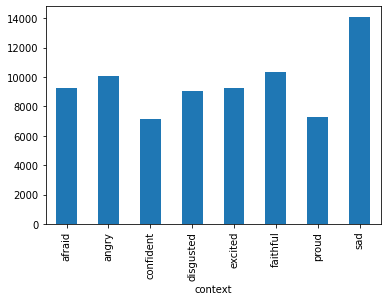

In [4]:
df.groupby(['context']).size().plot.bar()

In [26]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['context'])
c = list(le.classes_)
labels={}
for idx, la in enumerate(c):
    labels.update({la:idx})

['afraid' 'angry' 'confident' 'disgusted' 'excited' 'faithful' 'proud'
 'sad']


In [27]:
c = list(le.classes_)
labels={}
for idx, la in enumerate(c):
    labels.update({la:idx})
labels

{'afraid': 0,
 'angry': 1,
 'confident': 2,
 'disgusted': 3,
 'excited': 4,
 'faithful': 5,
 'proud': 6,
 'sad': 7}

In [28]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# labels = {'afraid':0,
#           'angry':1,
#           'anxious':2,
#           'disgusted':3,
#           'embarrassed':4,
#           'excited':5,
#           'guilty':6,
#           'jealous':7,
#           'joyful':8,
#           'lonely':9,
#           'proud':10,
#           'sad':11,
#           'sentimental':12,
#           'terrified':13,
#           'trusting':14,
#           }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [torch.tensor(labels[label], dtype=torch.long) for label in df['context']]
        self.texts  = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['utterance']]
        # self.story = torch.Tensor(tokenizer.convert_tokens_to_ids(self.texts)).long()

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [38]:
class Classifier(nn.Module):

    def __init__(self, dropout=0.3):

        super(Classifier, self).__init__()

        self.bert = bert
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(1024, 8)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [32]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    #GPU
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [33]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=4)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [34]:
np.random.seed(112)
# df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
#                                      [int(.8*len(df)), int(.9*len(df))])

print(len(df),len(val), len(test))

76622 6318 5701


In [39]:
EPOCHS = 5
model = Classifier()
LR = 1e-6
              
train(model, df, val, LR, EPOCHS)

  0%|          | 0/9578 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 23.70 GiB total capacity; 21.30 GiB already allocated; 102.50 MiB free; 21.38 GiB reserved in total by PyTorch)

In [ ]:
evaluate(model, test)

Test Accuracy:  0.996


In [ ]:
# Encode text 
input_text = "[CLS] [SYS] Hello, what can I help with you today? [USR] Find me a cheap restaurant nearby the north town."
input_tokens = tokenizer.tokenize(input_text)
story = torch.Tensor(tokenizer.convert_tokens_to_ids(input_tokens)).long()

if len(story.size()) == 1: 
    story = story.unsqueeze(0) # batch size dimension

if torch.cuda.is_available(): 
    bert = bert.cuda()
    story = story.cuda()

with torch.no_grad():
    input_context = {"input_ids": story, "attention_mask": (story > 0).long()}
    hiddens = tod_bert(**input_context)[0] 